# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.

In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-19 21:35:25.285918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 21:35:25.367582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training set, test set, and a test set with different distribution) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).

In [3]:
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 1  # Duration of audio clips in seconds
N_FFT = 2048  # Window size for Short-Time Fourier Transform. 512 samples corresponds to ~32 ms at 16 kHz.
HOP_LENGTH = 512 # Step size for the STFT windows. A value of 256 (~50% overlap) ensures good temporal resolution.
MAX_LEN = 45000  # The target length of audio files in samples (2 seconds at 16 kHz = 32000 samples).
RANDOM_STATE = 2159081 # For reproducibility

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and splitted into two arrays for better reuse.

In [4]:
# Define a function to load labels and split filenames from the protocol file
def load_labels(file_path):
    bonafide_files = []
    spoof_files = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            if label == "bonafide":
                bonafide_files.append(filename)
            else:
                spoof_files.append(filename)
    return np.array(bonafide_files), np.array(spoof_files)

# Load training labels
train_bonafide_filenames, train_spoof_filenames = load_labels(LABELS_TRAIN)
test_bonafide_filenames, test_spoof_filenames = load_labels(LABELS_TEST)
test_unseen_bonafide_filenames, test_unseen_spoof_filenames = load_labels(LABELS_UNSEEN_TEST)

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2580
Number of training spoof samples: 22800
Number of test bonafide samples: 2548
Number of test spoof samples: 22296
Number of unseen test bonafide samples: 7355
Number of unseen test spoof samples: 63882


### Section 2.2: Reduce data for test speed

In [5]:
def shuffle_and_trim_list(input_list, n=10000):
    # List and shuffle
    random.shuffle(input_list)

    return input_list[:n]

# ATTENTION: Dataset limiting --------------------------------
train_bonafide_filenames = shuffle_and_trim_list(train_bonafide_filenames, n=2500)
train_spoof_filenames = shuffle_and_trim_list(train_spoof_filenames, n=2000)
test_bonafide_filenames = shuffle_and_trim_list(test_bonafide_filenames, n=2000)
test_spoof_filenames = shuffle_and_trim_list(test_spoof_filenames, n=2000)
test_unseen_bonafide_filenames = shuffle_and_trim_list(test_unseen_bonafide_filenames, n=2000)
test_unseen_spoof_filenames = shuffle_and_trim_list(test_unseen_spoof_filenames, n=2000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2500
Number of training spoof samples: 2000
Number of test bonafide samples: 2000
Number of test spoof samples: 2000
Number of unseen test bonafide samples: 2000
Number of unseen test spoof samples: 2000


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and STFT Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to STFT format using `librosa`.
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [6]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# Function to load and preprocess audio files, ensuring all are standardized to the same length
def load_audio_files(dataset_path, file_list, sr=16000, max_len=32000):
    """
    Load and preprocess audio files from a specified dataset path.
    Ensures all audio signals are the same length by applying zero padding or trimming.

    Args:
        dataset_path (str): Path to the directory containing the audio files.
        file_list (list): List of file names (without extensions) to load.
        sr (int): Sampling rate for audio loading. Default is 16000.
        max_len (int): Target length for each audio signal (in samples).

    Returns:
        np.array: Array containing processed audio signals, all standardized to the same length.
    """
    audio_data = []
    for filename in tqdm(file_list, desc="Loading audio files"):
        file_path = os.path.join(dataset_path, f"{filename}.flac")
        try:
            # Load the audio file with the specified sampling rate
            audio, _ = librosa.load(file_path, sr=sr, duration=max_len / sr)

            # Ensure the audio length matches the target length (padding or trimming as needed)
            audio = librosa.util.fix_length(audio, size=max_len)

            # Add the processed audio signal to the list
            audio_data.append(audio)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # Return all processed audio signals as a numpy array
    return np.array(audio_data)

# Load bonafide and spoof samples for training, testing, and unseen testing datasets

# Training data for bonafide samples
audio_data_train_bonafide = load_audio_files(DATASET_TRAIN, train_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Training data for spoof samples
audio_data_train_spoof = load_audio_files(DATASET_TRAIN, train_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Test data for bonafide samples
audio_data_test_bonafide = load_audio_files(DATASET_TEST, test_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Test data for spoof samples
audio_data_test_spoof = load_audio_files(DATASET_TEST, test_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Unseen test data for bonafide samples
audio_data_unseen_test_bonafide = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Unseen test data for spoof samples
audio_data_unseen_test_spoof = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)

Loading audio files: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.52it/s]


### Section 3.2: Extract STFT features

In [7]:
# Function to extract Short-Time Fourier Transform (STFT) features from audio files
def compute_stft(audio_files, n_fft=2048, hop_length=512):
    """
    Extract Short-Time Fourier Transform (STFT) features from a list of audio signals.

    Args:
        audio_files (list): List of audio signals.
        n_fft (int): Number of FFT components. Default is 2048.
        hop_length (int): Number of samples between successive frames. Default is 512.

    Returns:
        np.array: Array containing the magnitude spectrograms for each audio signal.
    """
    stft_features = []  # Initialize a list to store STFT features for each audio file.
    
    for audio in tqdm(audio_files, desc="Extracting STFT features"):
        # Compute the Short-Time Fourier Transform (STFT) of the audio signal.
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        
        # Compute the magnitude spectrogram by taking the absolute value of the STFT result.
        spectrogram = np.abs(stft)
        
        # Append the magnitude spectrogram to the features list.
        stft_features.append(spectrogram)
    
    # Convert the list of spectrograms to a NumPy array and return it.
    return np.array(stft_features)

# Compute STFT for all samples
# Bonafide training samples
stft_data_train_bonafide = compute_stft(audio_data_train_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Spoof training samples
stft_data_train_spoof = compute_stft(audio_data_train_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Bonafide test samples
stft_data_test_bonafide = compute_stft(audio_data_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Spoof test samples
stft_data_test_spoof = compute_stft(audio_data_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Bonafide unseen test samples
stft_data_unseen_test_bonafide = compute_stft(audio_data_unseen_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Spoof unseen test samples
stft_data_unseen_test_spoof = compute_stft(audio_data_unseen_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)


Extracting STFT features: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1088.70it/s]


### Section 3.3: STFT data Visualization & Analysys

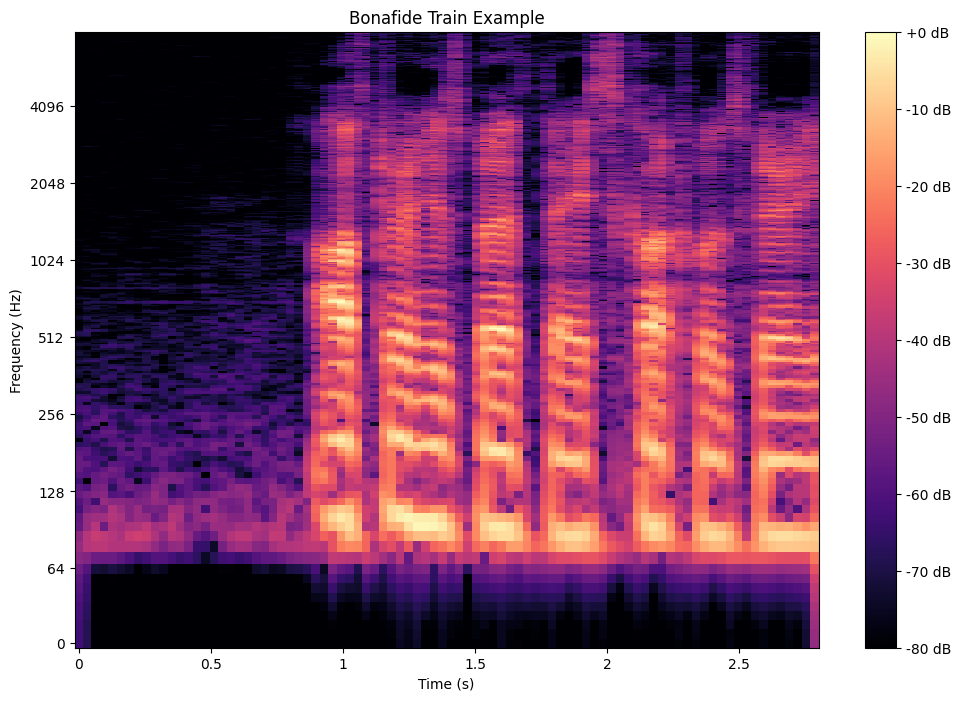

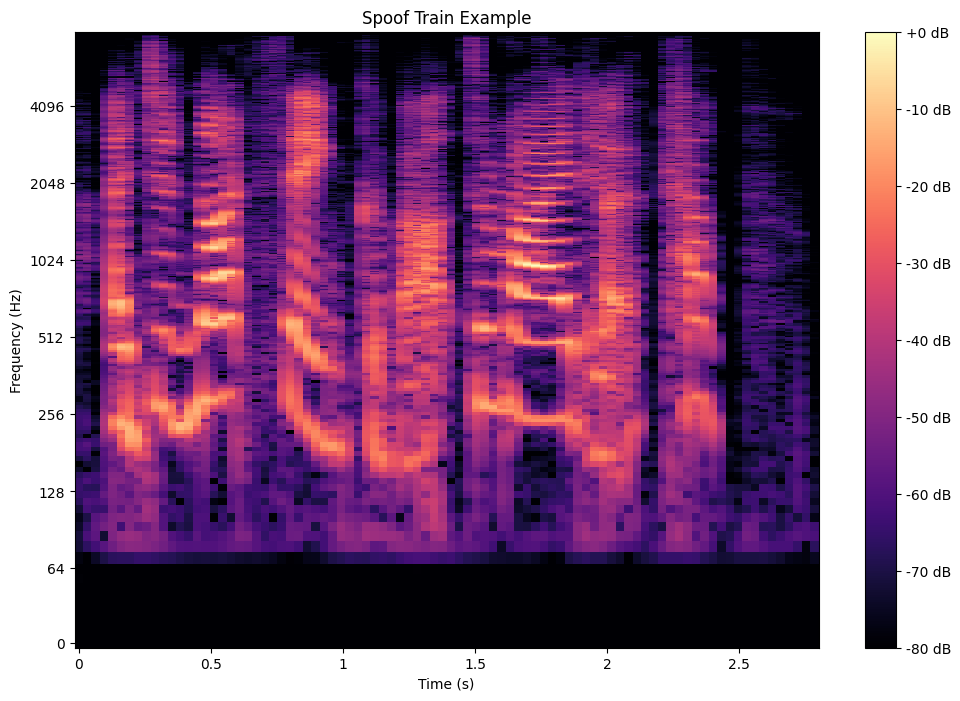

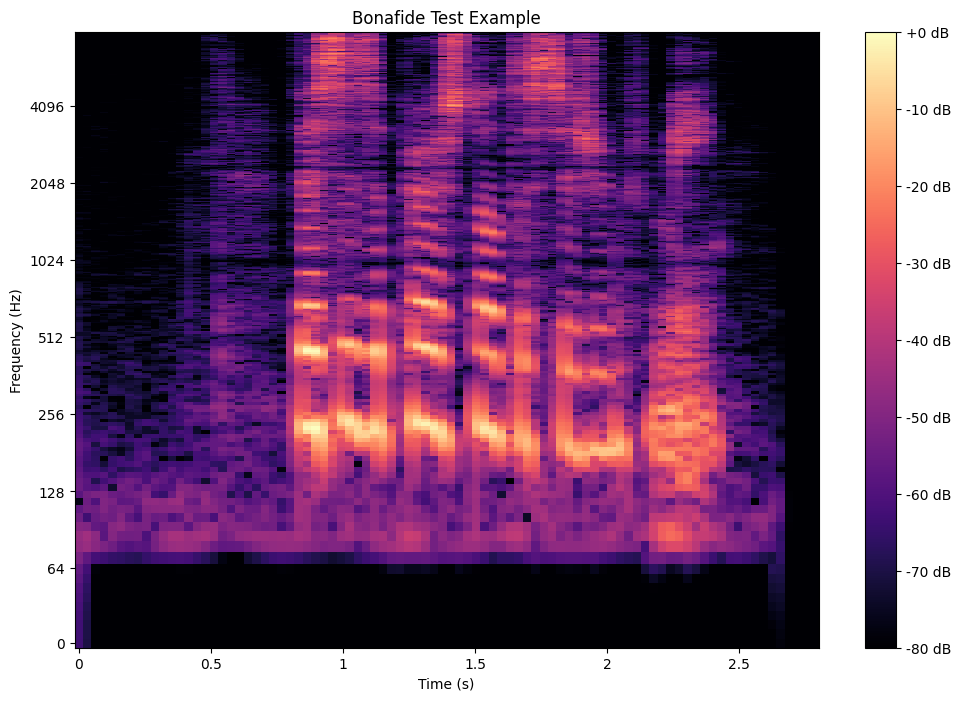

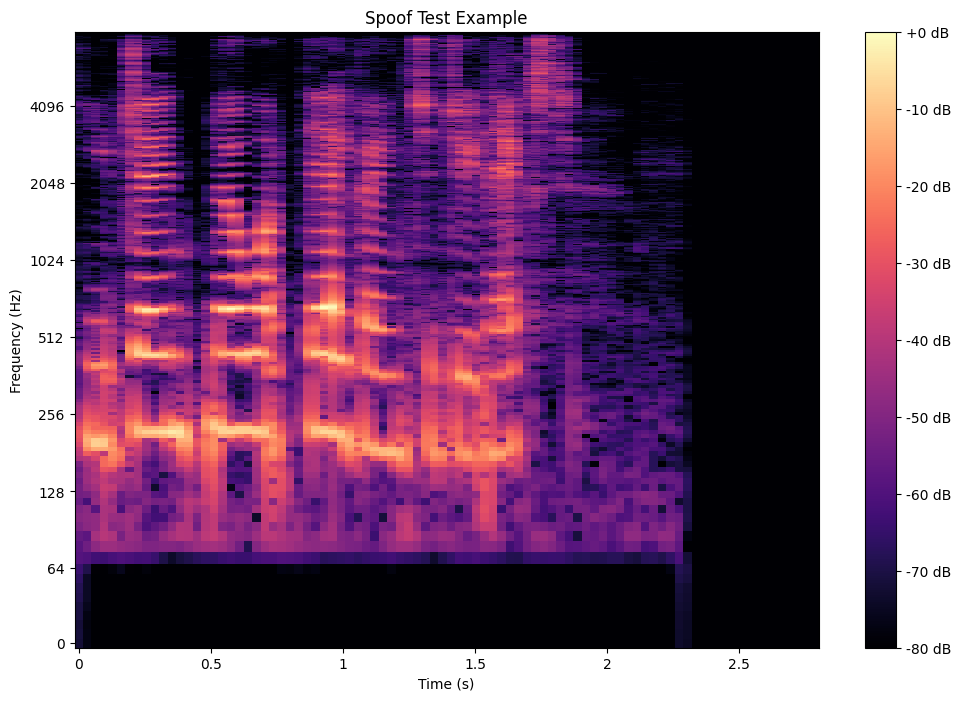

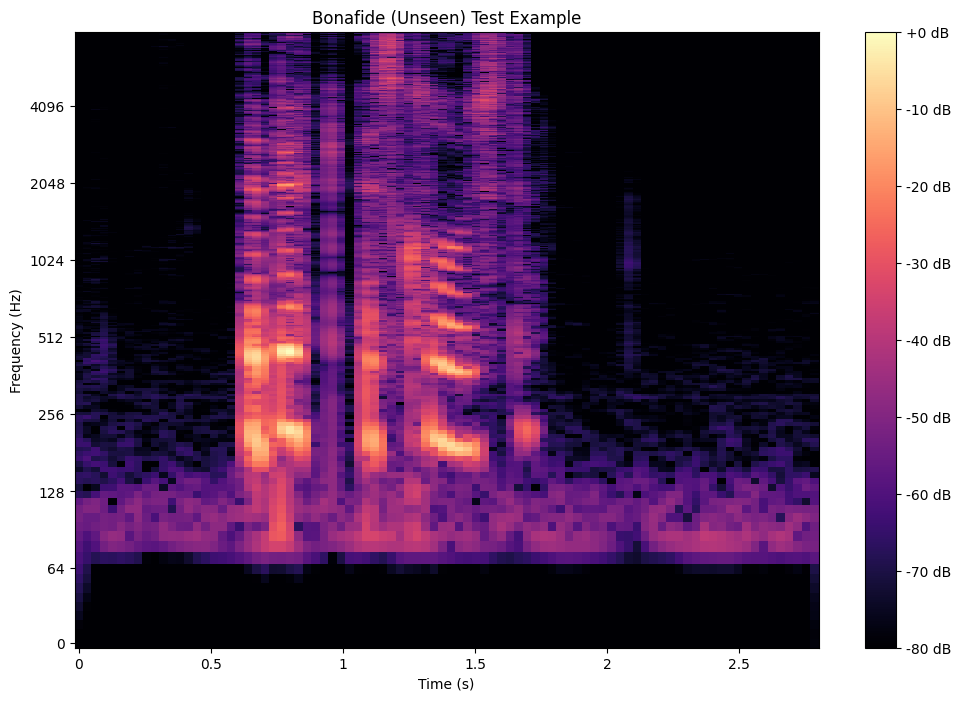

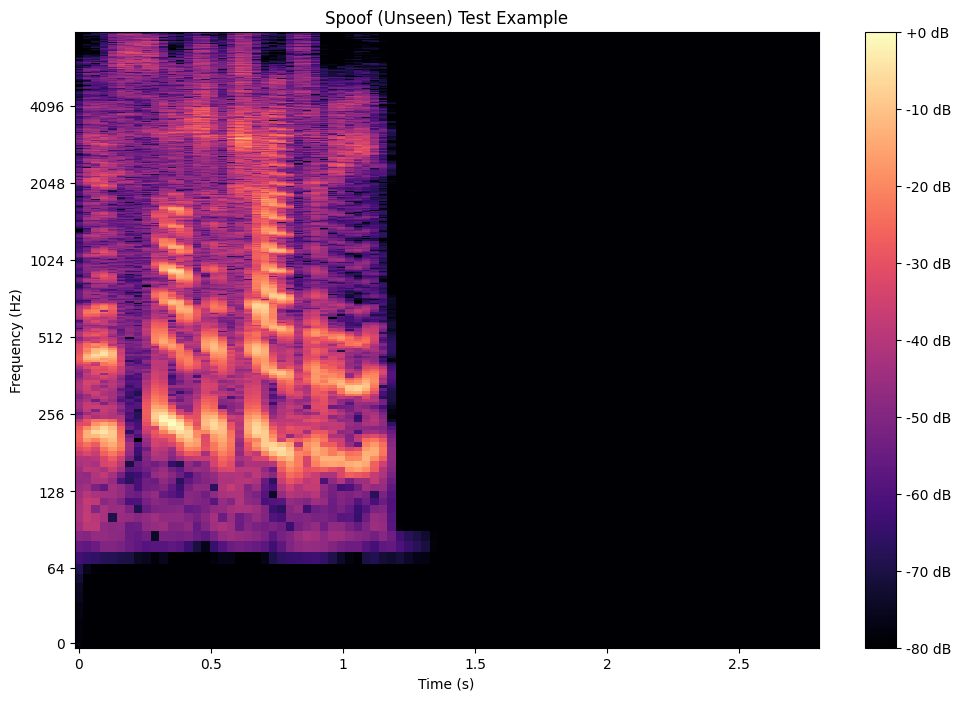

In [8]:
import random
import matplotlib.pyplot as plt

# Function to compute and visualize the spectrogram of an audio file
def plot_spectrogram(spectrogram, title, sr=16000, hop_length=512):
    """
    Visualize the spectrogram of an audio signal.

    Args:
        spectrogram (np.array): Magnitude spectrogram to visualize.
        title (str): Title of the plot.
        sr (int): Sampling rate of the audio signal. Default is 16000.
        hop_length (int): Hop length used in the STFT. Default is 512.
    """
    # Set up the figure for plotting
    plt.figure(figsize=(12, 8))
    
    # Display the spectrogram, converting amplitude values to decibels (dB)
    librosa.display.specshow(
        librosa.amplitude_to_db(spectrogram, ref=np.max),  # Convert amplitude to dB scale
        sr=sr,  # Sampling rate of the audio signal
        hop_length=hop_length,  # Hop length used in the STFT
        x_axis='time',  # Display time on the x-axis
        y_axis='log'    # Use a logarithmic scale for the frequency axis
    )
    
    # Add a color bar to indicate the dB scale
    plt.colorbar(format='%+2.0f dB')
    
    # Add plot title and axis labels
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Display the plot
    plt.show()

# Generate a random integer between 0 and 100 (inclusive)
random_number = random.randint(0, 100)

# Plot some examples
plot_spectrogram(stft_data_train_bonafide[random_number], "Bonafide Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_train_spoof[random_number], "Spoof Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_bonafide[random_number], "Bonafide Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_spoof[random_number], "Spoof Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_unseen_test_bonafide[random_number], "Bonafide (Unseen) Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_unseen_test_spoof[random_number], "Spoof (Unseen) Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)

# 4. Feature reduction: Autoencoder and Latent Space
### Section 4.1: Transpose the data to adapt it to autoencoder input

In [9]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler for feature scaling
scaler = MinMaxScaler()
scaler_fitted = 0

# Function to preprocess and transform STFT data
def preprocess_and_trasform_data(stft_data, string_data):
    """
    Preprocess and transform Short-Time Fourier Transform (STFT) data using MinMaxScaler.

    Args:
        stft_data (np.array): STFT data to preprocess and scale.
        string_data (str): Descriptor string for identifying the data being processed.

    Returns:
        np.array: Transformed STFT data.
    """
    print(f"Original {string_data} shape: {stft_data.shape}")

    # Transpose the STFT data for proper scaling
    stft_data = stft_data.transpose(0, 2, 1)
    print(f"Transposed {string_data} shape: {stft_data.shape}")

    # Apply MinMaxScaler to normalize the data
    if scaler_fitted == 0:
        stft_data = scaler.fit_transform(stft_data.reshape(-1, stft_data.shape[-1])).reshape(stft_data.shape)
    else:
        stft_data = scaler.transform(stft_data.reshape(-1, stft_data.shape[-1])).reshape(stft_data.shape)

    print(f"Scaled {string_data} shape: {stft_data.shape}\n\n")
    return stft_data

# Preprocess and transform STFT data for all sample sets
stft_data_train_bonafide = preprocess_and_trasform_data(stft_data_train_bonafide, "Train Bonafide")
stft_data_train_spoof = preprocess_and_trasform_data(stft_data_train_spoof, "Train Spoof")
stft_data_test_bonafide = preprocess_and_trasform_data(stft_data_test_bonafide, "Test Bonafide")
stft_data_test_spoof = preprocess_and_trasform_data(stft_data_test_spoof, "Test Spoof")
stft_data_unseen_test_bonafide = preprocess_and_trasform_data(stft_data_unseen_test_bonafide, "Test (Unseen) Bonafide")
stft_data_unseen_test_spoof = preprocess_and_trasform_data(stft_data_unseen_test_spoof, "Test (Unseen) Spoof")

Original Train Bonafide shape: (2500, 1025, 88)
Transposed Train Bonafide shape: (2500, 88, 1025)
Scaled Train Bonafide shape: (2500, 88, 1025)


Original Train Spoof shape: (2000, 1025, 88)
Transposed Train Spoof shape: (2000, 88, 1025)
Scaled Train Spoof shape: (2000, 88, 1025)


Original Test Bonafide shape: (2000, 1025, 88)
Transposed Test Bonafide shape: (2000, 88, 1025)
Scaled Test Bonafide shape: (2000, 88, 1025)


Original Test Spoof shape: (2000, 1025, 88)
Transposed Test Spoof shape: (2000, 88, 1025)
Scaled Test Spoof shape: (2000, 88, 1025)


Original Test (Unseen) Bonafide shape: (2000, 1025, 88)
Transposed Test (Unseen) Bonafide shape: (2000, 88, 1025)
Scaled Test (Unseen) Bonafide shape: (2000, 88, 1025)


Original Test (Unseen) Spoof shape: (2000, 1025, 88)
Transposed Test (Unseen) Spoof shape: (2000, 88, 1025)
Scaled Test (Unseen) Spoof shape: (2000, 88, 1025)




### Section 4.2: Autoencoder definition

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input dimensions for the autoencoder model
time_steps = 88  # The number of time steps in the input, adjusted to be divisible by 4
n_stft = 1025    # Number of STFT coefficients (features) per time step
latent_dim = 96  # The dimensionality of the latent space (bottleneck)

# Encoder: Extracts a latent representation from the input data
encoder_inputs = tf.keras.Input(shape=(time_steps, n_stft))  # Input layer defining the input shape
encoded = layers.LSTM(128, return_sequences=True)(encoder_inputs)  # First LSTM layer with 128 units, outputs sequences
encoded = layers.LSTM(latent_dim, return_sequences=False)(encoded)  # Second LSTM layer, reduces to latent_dim

# Decoder: Reconstructs the input data from the latent representation
decoded = layers.RepeatVector(time_steps)(encoded)  # Repeats the latent vector for each time step
decoded = layers.LSTM(128, return_sequences=True)(decoded)  # LSTM layer reconstructing intermediate sequences
decoded = layers.LSTM(n_stft, return_sequences=True)(decoded)  # Final LSTM layer reconstructing original input shape

# Autoencoder: Combines the encoder and decoder
autoencoder_sftf = models.Model(encoder_inputs, decoded, name="Autoencoder")  # Define the autoencoder model

# Encoder model: Captures the latent representation only
latent_model_sftf = models.Model(encoder_inputs, encoded, name="Encoder")  # Define the encoder model

# Compile the autoencoder model
autoencoder_sftf.compile(optimizer='adam', loss='mse')  # Using Adam optimizer and mean squared error loss

# Display model summaries for analysis
autoencoder_sftf.summary()  # Summary of the full autoencoder model
latent_model_sftf.summary()  # Summary of the encoder model

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 88, 1025)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 88, 128)        │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 88, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 88, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 88, 1025)       │     4,731,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,523,848 (21.07 MB)

 Trainable params: 5,523,848 (21.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 88, 1025)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 88, 128)        │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,248 (2.58 MB)

 Trainable params: 677,248 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

### Section 4.3: Autoencoder training

In [11]:
# Train the autoencoder model using the bonafide training data
autoencoder_sftf.fit(
    stft_data_train_bonafide,  # Input data for training (bonafide samples)
    stft_data_train_bonafide,  # Target data (same as input for reconstruction)
    epochs=5,                  # Number of training epochs
    batch_size=32,             # Number of samples per gradient update
    validation_split=0.2,      # Fraction of training data to be used as validation data
    verbose=1                  # Verbosity mode (1 = progress bar, 0 = silent)
)

Epoch 1/5


2025-01-19 21:37:41.227033: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 531ms/step - loss: 7.0660e-04 - val_loss: 6.5508e-04
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 524ms/step - loss: 6.5517e-04 - val_loss: 6.3341e-04
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - loss: 6.3895e-04 - val_loss: 6.0310e-04
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - loss: 6.3203e-04 - val_loss: 5.9271e-04
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 556ms/step - loss: 6.0530e-04 - val_loss: 5.8450e-04


### Section 4.4: Rebuilt testset and plot reconstruction error

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step


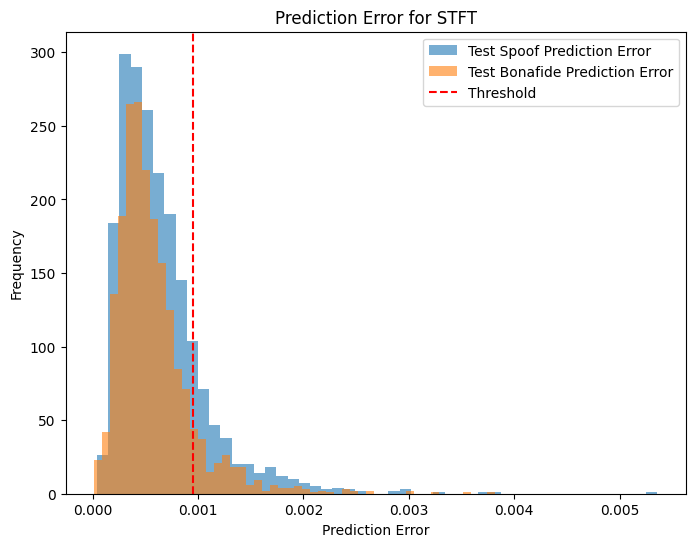

In [12]:
import matplotlib.pyplot as plt

# Use the trained autoencoder to reconstruct the test datasets
predicted_data_test_bonafide = autoencoder_sftf.predict(stft_data_test_bonafide)  # Reconstruct bonafide test samples
predicted_data_test_spoof = autoencoder_sftf.predict(stft_data_test_spoof)        # Reconstruct spoof test samples

# Calculate the Mean Squared Error (MSE) for reconstruction loss
test_bonafide_loss = np.mean(np.square(stft_data_test_bonafide - predicted_data_test_bonafide), axis=(1, 2))  # MSE for bonafide
test_spoof_loss = np.mean(np.square(stft_data_test_spoof - predicted_data_test_spoof), axis=(1, 2))           # MSE for spoof

# Plot histograms of reconstruction errors
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(test_spoof_loss, bins=50, alpha=0.6, label='Test Spoof Prediction Error')  # Histogram for spoof samples
plt.hist(test_bonafide_loss, bins=50, alpha=0.6, label='Test Bonafide Prediction Error')  # Histogram for bonafide samples

# Add a vertical line to represent the threshold for classification
plt.axvline(np.mean(test_bonafide_loss) + 1 * np.std(test_bonafide_loss), color='r', linestyle='--', label='Threshold')

# Add title, labels, and legend to the plot
plt.title("Prediction Error for STFT")  # Title of the plot
plt.xlabel("Prediction Error")         # X-axis label
plt.ylabel("Frequency")                # Y-axis label
plt.legend()                           # Display legend

# Show the plot
plt.show()

### Section 4.5: Extract and evaluate latent space for dimensionality reduction

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
(2500, 96)
(2000, 96)
(2000, 96)
Classification Report (bonafide sample First):
                 precision    recall  f1-score   support

   spoof sample       0.60      0.16      0.26      2000
bonafide sample       0.52      0.89      0.65      2000

       accuracy                           0.53      4000
      macro avg       0.56      0.53      0.46      4000
   weighted avg       0.56      0.53      0.46      4000

ROC-AUC Score: 0.55


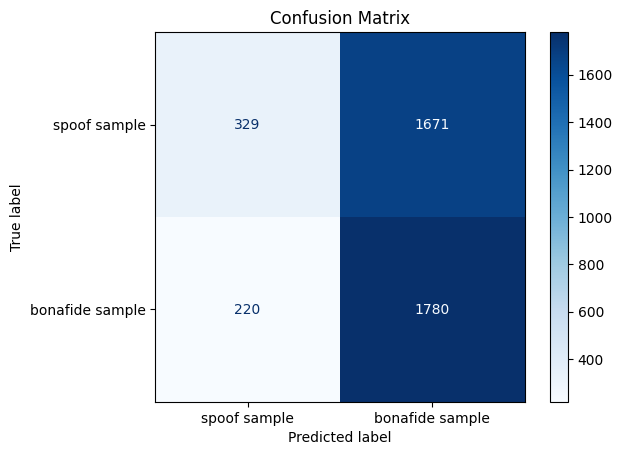

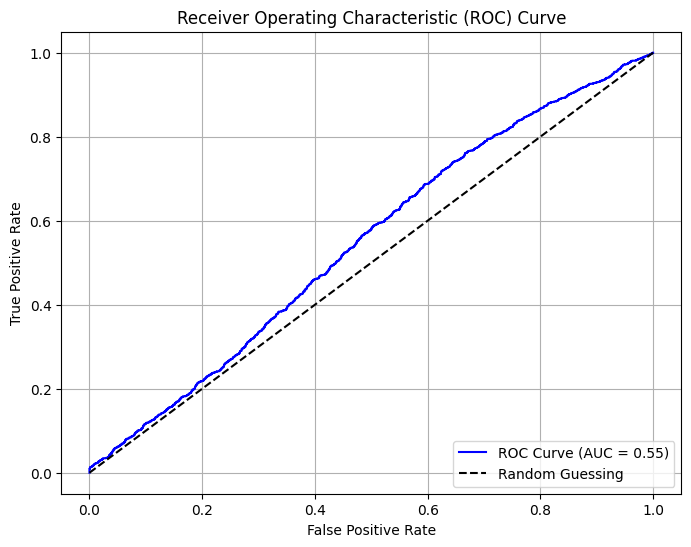

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict the latent space representations for train, test bonafide, and test spoof datasets
latent_stft_train_bonafide = latent_model_sftf.predict(stft_data_train_bonafide)  # Latent space for bonafide training samples
latent_stft_test_bonafide = latent_model_sftf.predict(stft_data_test_bonafide)  # Latent space for bonafide test samples
latent_stft_test_spoof = latent_model_sftf.predict(stft_data_test_spoof)        # Latent space for spoof test samples

# Display the shape of latent space representations
print(latent_stft_train_bonafide.shape)
print(latent_stft_test_bonafide.shape)
print(latent_stft_test_spoof.shape)

# Calculate the detection threshold using the reconstruction loss for bonafide test samples
threshold = np.mean(test_bonafide_loss) + 1 * np.std(test_bonafide_loss)  # Threshold = Mean + 1 standard deviation

# Classify samples based on the threshold
test_bonafide_predictions = (test_bonafide_loss < threshold).astype(int)  # 1 = bonafide, 0 = spoof
test_spoof_predictions = (test_spoof_loss < threshold).astype(int)        # 1 = bonafide, 0 = spoof

# Create true labels for the datasets
y_true_labels = np.concatenate([np.ones(len(test_bonafide_loss)), np.zeros(len(test_spoof_loss))])  # 1 = bonafide, 0 = spoof

# Combine predictions from both datasets
y_predicted_labels = np.concatenate([test_bonafide_predictions, test_spoof_predictions])

# Print classification report for evaluation
print("Classification Report (bonafide sample First):")
print(classification_report(y_true_labels, y_predicted_labels, target_names=["spoof sample", "bonafide sample"]))

# Calculate and display the ROC-AUC score
y_scores = np.concatenate([1 - test_bonafide_loss / threshold, 1 - test_spoof_loss / threshold])  # Normalized scores for ROC-AUC
roc_auc = roc_auc_score(y_true_labels, y_scores)  # Compute ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot the confusion matrix
cm = confusion_matrix(y_true_labels, y_predicted_labels)  # Compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof sample", "bonafide sample"])  # Configure display
disp.plot(cmap="Blues")  # Display the confusion matrix with a blue colormap
plt.title("Confusion Matrix")  # Title for the plot
plt.show()  # Show the confusion matrix plot

# Plot the Receiver Operating Characteristic (ROC) curve
fpr, tpr, _ = roc_curve(y_true_labels, y_scores)  # Compute False Positive Rate and True Positive Rate
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")  # Plot the ROC curve with AUC
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")  # Add diagonal line for random guessing
plt.xlabel("False Positive Rate")  # X-axis label
plt.ylabel("True Positive Rate")  # Y-axis label
plt.title("Receiver Operating Characteristic (ROC) Curve")  # Title for the ROC curve plot
plt.legend(loc="lower right")  # Place the legend at the bottom-right corner
plt.grid()  # Add grid lines for better visualization
plt.show()  # Show the ROC curve plot


# 5. One-Class SVM
### Section 5.1: Rescale latent data

In [14]:
import sklearn.utils as sk_utils
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize MinMaxScaler for normalizing latent space data
scaler = MinMaxScaler()  # Scaler to normalize data between 0 and 1

# Scale latent space data for the bonafide training dataset
latent_stft_train_bonafide = scaler.fit_transform(latent_stft_train_bonafide)  # Fit to training data and transform

# Apply the same scaler to transform the bonafide test dataset
latent_stft_test_bonafide = scaler.transform(latent_stft_test_bonafide)  # Normalize test bonafide samples

# Apply the same scaler to transform the spoof test dataset
latent_stft_test_spoof = scaler.transform(latent_stft_test_spoof)  # Normalize spoof samples

### Section 5.2 Define the model and the labels

In [15]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the training data for One-Class SVM
X_one = latent_stft_train_bonafide  # Latent space features for bonafide training samples
y_one = np.ones(X_one.shape[0])  # Assign all training samples a label of 1 (normal/bonafide)

# Initialize the One-Class SVM model
ocsvm = OneClassSVM()  # One-Class SVM for anomaly detection

# Define the hyperparameter grid for grid search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types for the SVM
    'nu': [0.1, 0.2, 0.3, 0.4],  # Anomaly detection parameter (fraction of anomalies)
    'gamma': ['scale', 'auto', 0.1, 0.5]  # Kernel coefficient for RBF/poly kernels
}

### Section 5.3: Fit the model with paramgrid

In [16]:
# Perform Grid Search with Cross-Validation to optimize hyperparameters
grid_search = GridSearchCV(
    ocsvm,                   # One-Class SVM model to optimize
    param_grid,              # Dictionary of hyperparameter options
    cv=5,                    # Number of cross-validation folds
    n_jobs=-1,               # Use all available CPU cores for parallel processing
    scoring='accuracy'       # Scoring metric to evaluate model performance
)

# Fit the grid search model using the training data
grid_search.fit(X_one, y_one)

# Retrieve and display the best hyperparameters found during the grid search
best_params = grid_search.best_params_  # Best combination of hyperparameters
print("Best parameters found:", best_params)

# Retrieve and display the mean cross-validation score for the best hyperparameters
best_score = grid_search.best_score_  # Mean CV score for the best model
print(f"Mean cross-validation score with best parameters: {best_score:.4f}")

Best parameters found: {'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.1}
Mean cross-validation score with best parameters: 0.9000


### Section 5.4: Do testing

In [17]:
# Retrieve the best One-Class SVM model from the grid search
best_model_one_svm = grid_search.best_estimator_  # Optimal model with best hyperparameters

# Prepare the test datasets for evaluation
X_test_bonafide = latent_stft_test_bonafide  # Latent space features for bonafide test samples
y_test_bonafide = np.ones(X_test_bonafide.shape[0])  # Assign label 1 to bonafide samples

X_test_spoof = latent_stft_test_spoof  # Latent space features for spoof test samples
y_test_spoof = -np.ones(X_test_spoof.shape[0])  # Assign label -1 to spoof samples

# Combine bonafide and spoof test datasets for evaluation
X_test_one = np.concatenate([X_test_bonafide, X_test_spoof], axis=0)  # Combine features for bonafide and spoof samples
y_test_one = np.concatenate([y_test_bonafide, y_test_spoof], axis=0)  # Combine labels for bonafide (1) and spoof (-1)

# Predict the labels of the combined test dataset using the best One-Class SVM model
y_pred_one = best_model_one_svm.predict(X_test_one)  # Predictions: 1 = bonafide, -1 = spoof


### Section 5.5: Show results


Classification Report on Bonafide and Spoof Samples:
                 precision    recall  f1-score   support

   Spoof Sample       0.59      0.15      0.23      2000
Bonafide Sample       0.51      0.90      0.65      2000

       accuracy                           0.52      4000
      macro avg       0.55      0.52      0.44      4000
   weighted avg       0.55      0.52      0.44      4000



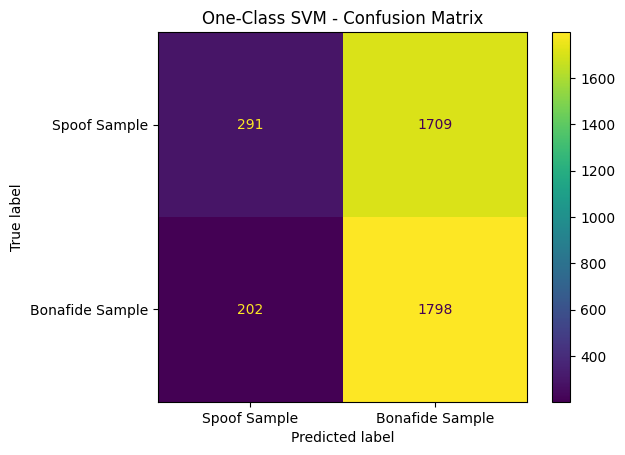

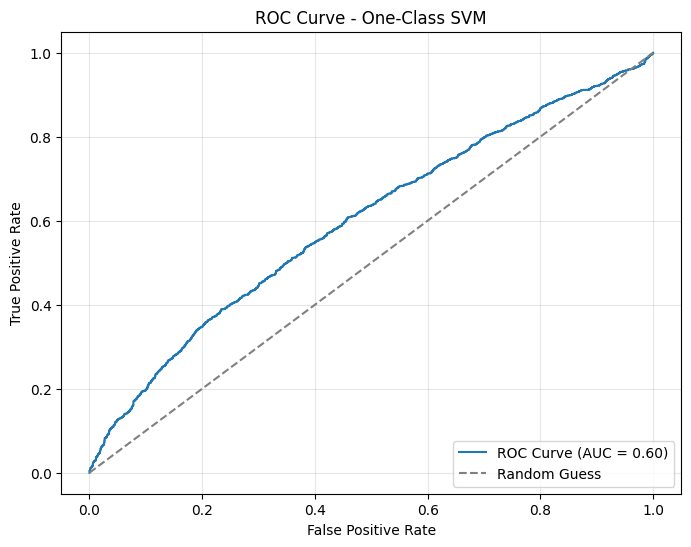

ROC-AUC Score: 0.5993


In [18]:
# Display the classification report
print("\nClassification Report on Bonafide and Spoof Samples:")
print(classification_report(y_test_one, y_pred_one, target_names=["Spoof Sample", "Bonafide Sample"]))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_one, y_pred_one, display_labels=["Spoof Sample", "Bonafide Sample"])
plt.title("One-Class SVM - Confusion Matrix")
plt.show()

# Calculate the decision function values for ROC-AUC computation
y_scores_one = best_model_one_svm.decision_function(X_test_one)

# Calculate the ROC-AUC score and ROC curve points
roc_auc = roc_auc_score((y_test_one == 1).astype(int), y_scores_one)  # Binary labels (1: bonafide, 0: spoof)
fpr, tpr, thresholds = roc_curve((y_test_one == 1).astype(int), y_scores_one)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")  # ROC curve with AUC value
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")  # Diagonal for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One-Class SVM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Output the ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.4f}")


### Section 5.6 Save the model

In [19]:
import joblib  # Per salvare e caricare il modello

# Salva il miglior modello One-Class SVM su file
model_filename = "STFT_Autoencoder_OCSVM.pkl"
joblib.dump(best_model_one_svm, model_filename)
print(f"The best model has been saved to '{model_filename}'.")

# (Opzionale) Carica il modello salvato per verifica
loaded_model = joblib.load(model_filename)
print("Model loaded successfully for verification.")

The best model has been saved to 'STFT_Autoencoder_OCSVM.pkl'.
Model loaded successfully for verification.
